In [1111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
import warnings

warnings.filterwarnings('ignore')

In [1112]:
#pip uninstall scikit-learn

In [1113]:
#pip install scikit-learn==1.2.2

In [1114]:
data=pd.read_csv("online_shoppers_intention.csv")

In [1115]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [1116]:
data.shape


(12330, 18)

In [1117]:
print(data.duplicated().sum())


125


In [1118]:
data=data.drop_duplicates()

In [1119]:
data.shape

(12205, 18)

In [1120]:
numerical_columns=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend','Revenue']

In [1121]:
data['Revenue'].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [1122]:
data['VisitorType'].value_counts()

VisitorType
Returning_Visitor    10431
New_Visitor           1693
Other                   81
Name: count, dtype: int64

In [1123]:
data['Weekend'].value_counts()

Weekend
False    9346
True     2859
Name: count, dtype: int64

In [1124]:
# IQR function 
def IQR(x):
    x = x.astype(np.float32)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    bb = q1 - 1.5*(q3 - q1)
    ba = q3 + 1.5*(q3 - q1)
    outlier_indices = list(x.index[(x < bb) | (x > ba)])
    outlier_values = list(x[outlier_indices])
    return len(outlier_indices)

In [1125]:
total_outliers=0
for i in numerical_columns:
    print(f'Number of IQR outliers {i}: {IQR(data[i])}')

Number of IQR outliers Administrative: 404
Number of IQR outliers Administrative_Duration: 1149
Number of IQR outliers Informational: 2631
Number of IQR outliers Informational_Duration: 2405
Number of IQR outliers ProductRelated: 1007
Number of IQR outliers ProductRelated_Duration: 951
Number of IQR outliers BounceRates: 1428
Number of IQR outliers ExitRates: 1325
Number of IQR outliers PageValues: 2730
Number of IQR outliers SpecialDay: 1249


In [1126]:
total_outliers = 0
total_data_points = 0

for i in numerical_columns:
    outliers = IQR(data[i])
    total_outliers += outliers
    total_data_points += len(data[i])

total_outlier_percentage = (total_outliers / total_data_points) * 100

print(f'Total outlier percentage: {total_outlier_percentage:.2f}%')

Total outlier percentage: 12.52%


In [1127]:
class AddNewVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['Administrative_Duration_Page'] = X['Administrative_Duration']/data['Administrative']
        X['Informational_Duration_Page'] = X['Informational_Duration']/data['Informational']
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration']/data['ProductRelated']
        
        # division by zero becomes zero
        X['Administrative_Duration_Page'] = X['Administrative_Duration_Page'].fillna(0)
        X['Informational_Duration_Page'] = X['Informational_Duration_Page'].fillna(0)
        X['ProductRelated_Duration_Page'] = X['ProductRelated_Duration_Page'].fillna(0)
     
        return X


In [1128]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns_to_drop)

In [1129]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [1130]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [1131]:
zero_rows_indices = data[(data[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration']] == 0.0).all(axis=1)].index


data = data.drop(zero_rows_indices)

In [1132]:
data.shape

(12199, 18)

In [1133]:
X = data.drop(['Revenue'], axis = 1)
y = data['Revenue']

In [1134]:
count_zero_rows = (data[['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration']]==0.000000).all(axis=1).sum()
print(count_zero_rows)

0


In [1135]:
y

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12199, dtype: bool

In [1136]:
y.shape

(12199,)

## Run this after EDA

In [1145]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1146]:
pipe = Pipeline([
    ('add_new_vars', AddNewVariables()),
    ('drop_old_vars', DropVariables(columns_to_drop=['Administrative', 'Informational', 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration'])),
    ('oneHot',oneHot(columns=['Weekend','Month','VisitorType','OperatingSystems','Browser','Region','TrafficType'])),
    ('scaler',StdScaler())
])

In [1147]:
pipe1 = clone(pipe)

In [1148]:
x_train

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
3134,0,0.000000,0,0.0,4,118.000000,0.050000,0.066667,0.000000,0.0,May,1,1,2,3,Returning_Visitor,False
7088,3,75.400000,0,0.0,18,1051.420000,0.009524,0.019048,0.000000,0.0,Rest,2,3,2,2,New_Visitor,False
3077,0,0.000000,0,0.0,5,215.000000,0.040000,0.080000,0.000000,1.0,May,3,2,3,2,Returning_Visitor,False
4775,1,21.000000,0,0.0,31,945.666667,0.006897,0.010345,0.000000,0.0,May,2,2,1,4,New_Visitor,False
9917,0,0.000000,0,0.0,2,11.000000,0.000000,0.100000,0.000000,0.0,Nov,3,2,1,5,Returning_Visitor,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12092,0,0.000000,0,0.0,11,332.125000,0.036364,0.090909,0.000000,0.0,Nov,2,2,5,3,Returning_Visitor,False
5274,1,48.000000,0,0.0,26,1066.666667,0.025000,0.042024,0.000000,0.0,May,3,2,5,5,Returning_Visitor,False
5477,7,227.900000,0,0.0,22,701.016667,0.000000,0.001667,0.000000,0.0,Rest,2,3,4,2,Returning_Visitor,False
874,3,64.500000,0,0.0,35,1334.551371,0.000000,0.007310,0.000000,0.0,Mar,3,2,4,2,Returning_Visitor,True


In [1149]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [1150]:
X_train

,SpecialDay,Weekend_True,Month_June,Month_Mar,Month_May,Month_Nov,Month_Rest,VisitorType_Other,VisitorType_Returning_Visitor,OperatingSystems_2,...,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_13,BounceRates,ExitRates,PageValues,Administrative_Duration_Page,Informational_Duration_Page,ProductRelated_Duration_Page
3134,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.652809,0.543101,-0.317612,-0.470635,-0.22189,-0.189580
7088,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,-0.238459,-0.484134,-0.317612,0.119281,-0.22189,0.452960
3077,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.432613,0.830727,-0.317612,-0.470635,-0.22189,0.110442
4775,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,-0.296310,-0.671870,-0.317612,0.022266,-0.22189,-0.167236
9917,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.448169,1.262165,-0.317612,-0.470635,-0.22189,-0.722951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12092,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.352542,1.066057,-0.317612,-0.470635,-0.22189,-0.174175
5274,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.102320,0.011507,-0.317612,0.655995,-0.22189,0.066564
5477,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,-0.448169,-0.859075,-0.317612,0.293529,-0.22189,-0.137034
874,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.448169,-0.737346,-0.317612,0.034002,-0.22189,0.002213


In [1151]:
X_train.shape

(8539, 29)

In [1152]:
X_train.columns

Index(['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'Browser_2', 'Browser_3',
       'Region_2', 'Region_3', 'Region_4', 'Region_5', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_13',
       'BounceRates', 'ExitRates', 'PageValues',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page'],
      dtype='object')

In [1153]:
X_test.columns

Index(['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'Browser_2', 'Browser_3',
       'Region_2', 'Region_3', 'Region_4', 'Region_5', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_13',
       'BounceRates', 'ExitRates', 'PageValues',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page'],
      dtype='object')

In [1154]:
y_train

3134     False
7088     False
3077     False
4775     False
9917     False
         ...  
12092    False
5274     False
5477     False
874      False
7361      True
Name: Revenue, Length: 8539, dtype: bool

In [1155]:
numerical_columns=['Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [1156]:
smt=SMOTE()
X_train_smote,y_train_smote=smt.fit_resample(X_train,y_train)

In [1157]:
X_train_smote.shape

(14364, 29)

In [1158]:
print('AFTER oversampling (smote)')
print(pd.Series(y_train_smote).value_counts())

AFTER oversampling (smote)
Revenue
False    7182
True     7182
Name: count, dtype: int64


# EDA

In [1137]:
# x_train.columns

In [663]:
categorical_columns=['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']

In [664]:
numericCols=['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

In [1138]:
# plt.figure(figsize=(12 , 10))
# sns.heatmap(x_train[numericCols].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
# plt.title('Correlation Heatmap')

In [573]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')


for column in categorical_columns:
    ChiSquareContingency(x_train[column], y_train)
    print('')

p-value: 1.0532915832240254e-49
Reject H0, feature Month is dependent with Revenue

p-value: 4.420182767066027e-10
Reject H0, feature OperatingSystems is dependent with Revenue

p-value: 0.09727116796731065
Accept H0, feature Browser is independent with Revenue

p-value: 0.7009011101514953
Accept H0, feature Region is independent with Revenue

p-value: 3.192630074547758e-47
Reject H0, feature TrafficType is dependent with Revenue

p-value: 1.620183332359562e-24
Reject H0, feature VisitorType is dependent with Revenue

p-value: 0.010491300356030853
Reject H0, feature Weekend is dependent with Revenue



In [ ]:
# fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# sns.boxplot(ax=axes[0, 0], x=y_train, y=x_train['Administrative_Duration'])
# sns.boxplot(ax=axes[0, 1], x=y_train, y=x_train['Informational_Duration'])
# sns.boxplot(ax=axes[0, 2], x=y_train, y=x_train['ProductRelated_Duration'])
# sns.boxplot(ax=axes[1, 0], x=y_train, y=x_train['BounceRates'])
# sns.boxplot(ax=axes[1, 1], x=y_train, y=x_train['ExitRates'])
# sns.boxplot(ax=axes[1, 2], x=y_train, y=x_train['PageValues'])
# sns.boxplot(ax=axes[2, 0], x=y_train, y=x_train['SpecialDay'])
# sns.boxplot(ax=axes[2, 1], x=y_train, y=x_train['Administrative'])
# sns.boxplot(ax=axes[2, 2], x=y_train, y=x_train['Informational'])
# sns.boxplot(ax=axes[3, 0], x=y_train, y=x_train['ProductRelated'])



In [575]:
y_train.shape

(8539,)

In [576]:
x_train.shape

(8539, 17)

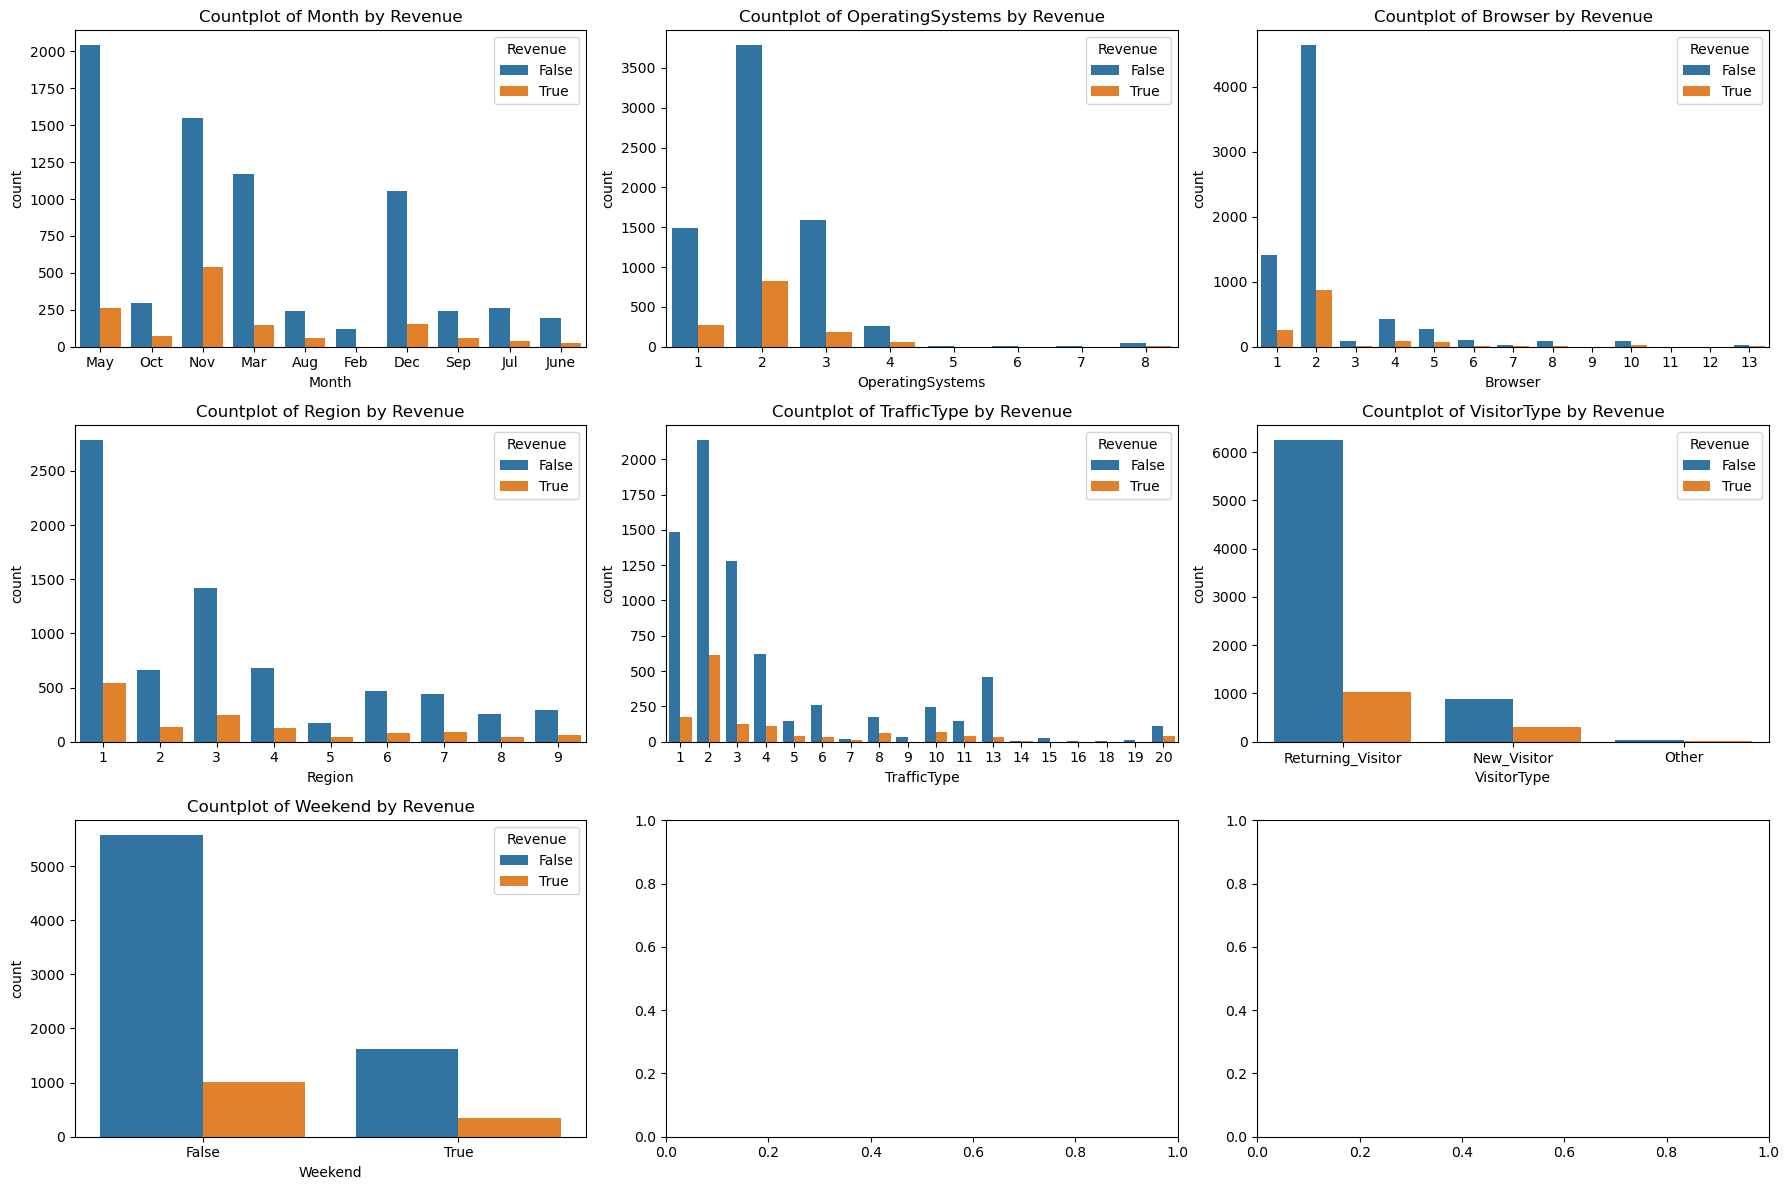

In [577]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=x_train[column], hue=y_train, ax=axes[i])
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')

plt.tight_layout()
plt.show()

In [1139]:
categories_to_combine1 = [4,5,6,7,8]
new_category_name1 = 4

X['OperatingSystems'] = X['OperatingSystems'].replace(categories_to_combine1, new_category_name1)


In [1140]:
categories_to_combine2 = [3,4,5,6,7,8,9,10,11,12,13]
new_category_name2 = 3

X['Browser'] = X['Browser'].replace(categories_to_combine2, new_category_name2)


categories_to_combine3 = [5,6,7,8,9,10,11,12,14,15,16,17,18,19,20]
new_category_name3 = 5

X['TrafficType'] = X['TrafficType'].replace(categories_to_combine3, new_category_name3)



In [1141]:
categories_to_combine4 = ['Oct','Aug','Feb','Sep','Jul','Jun']
new_category_name4 = 'Rest'

X['Month'] = X['Month'].replace(categories_to_combine4, new_category_name4)

# categories_to_combine5 = ['May','June','Jul','Aug','Sep']
# new_category_name5 = 'Months2'

# X['Month'] = X['Month'].replace(categories_to_combine5, new_category_name5)

# categories_to_combine6 = ['Feb','Mar']
# new_category_name6 = 'Months3'

# X['Month'] = X['Month'].replace(categories_to_combine6, new_category_name6)

categories_to_combine7 = [5,6,7,8,9]
new_category_name7 = 5

X['Region'] = X['Region'].replace(categories_to_combine7, new_category_name7)


In [1142]:
categories_to_combine8 = [0.2,0.4,0.6,0.8,1.0]
new_category_name8 = 1.0

X['SpecialDay'] = X['SpecialDay'].replace(categories_to_combine8, new_category_name8)


<Axes: xlabel='SpecialDay', ylabel='count'>

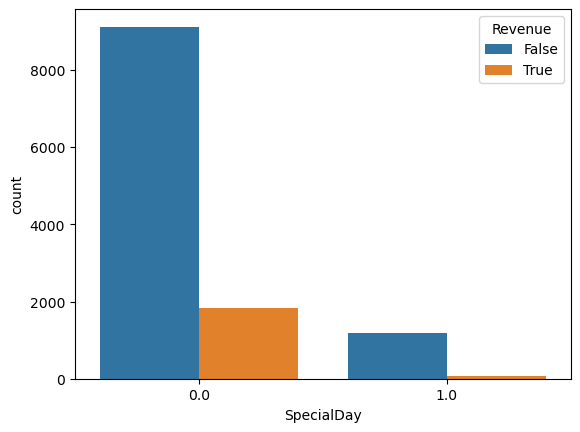

In [1143]:
sns.countplot(x=X['SpecialDay'], hue=y)

KeyError: 'Revenue'

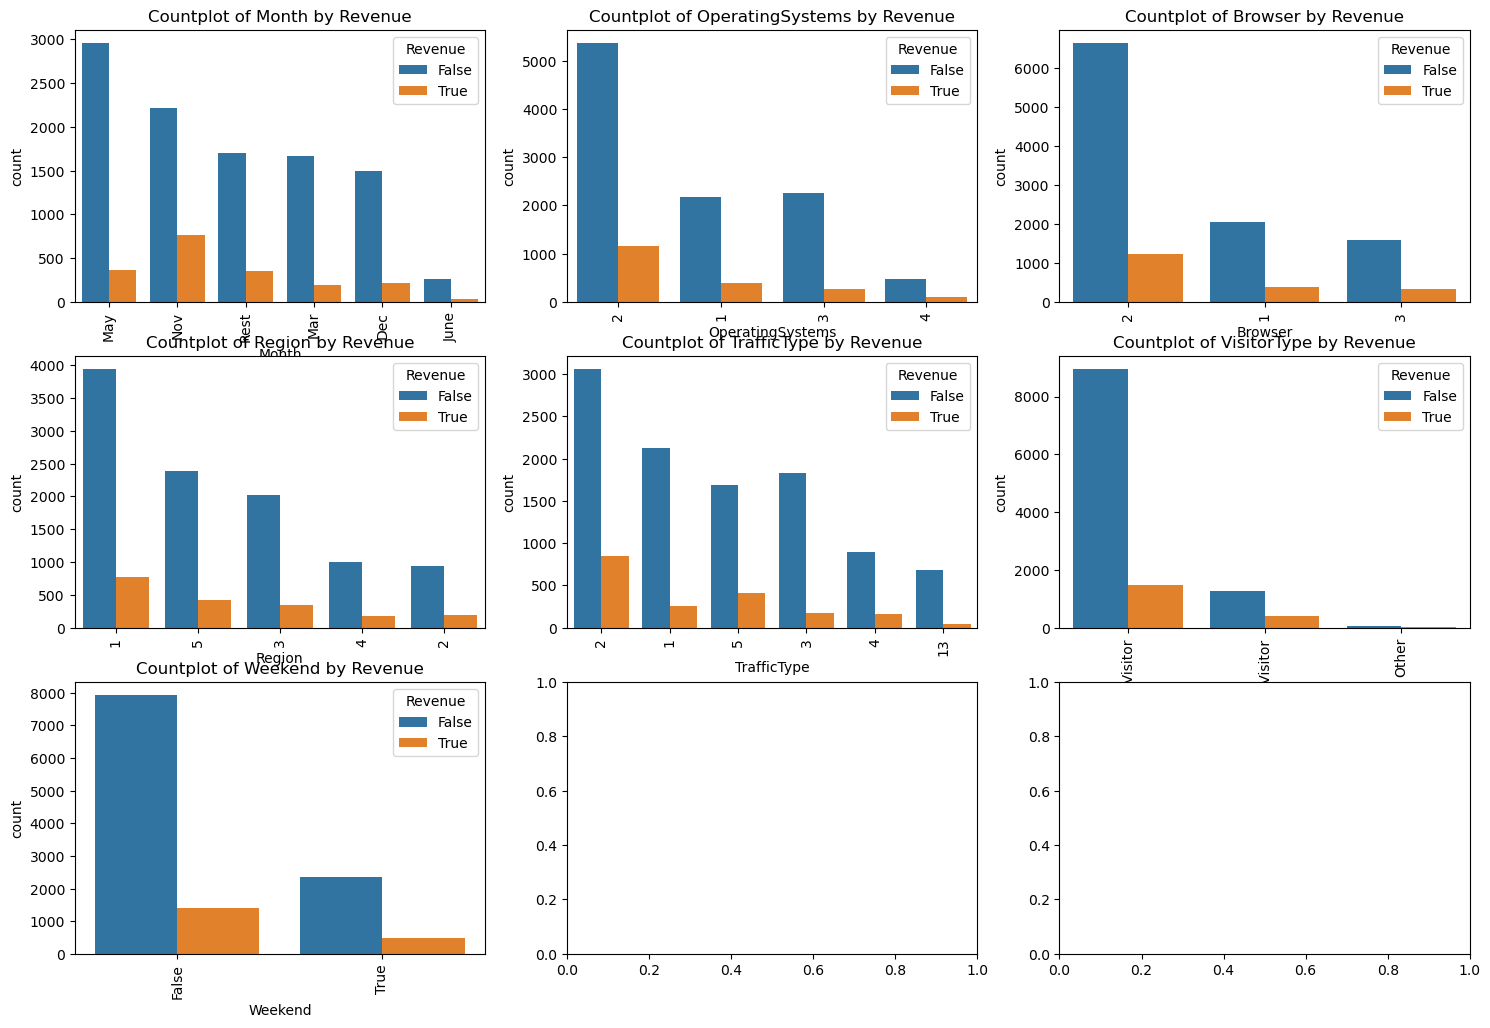

In [1144]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    sns.countplot(x=X[column], hue=y, ax=axes[i],order=X[column].value_counts().index)
    axes[i].set_title(f'Countplot of {column} by Revenue')
    axes[i].legend(title='Revenue')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# after SMOTE


Text(0.5, 1.0, 'Correlation Heatmap')

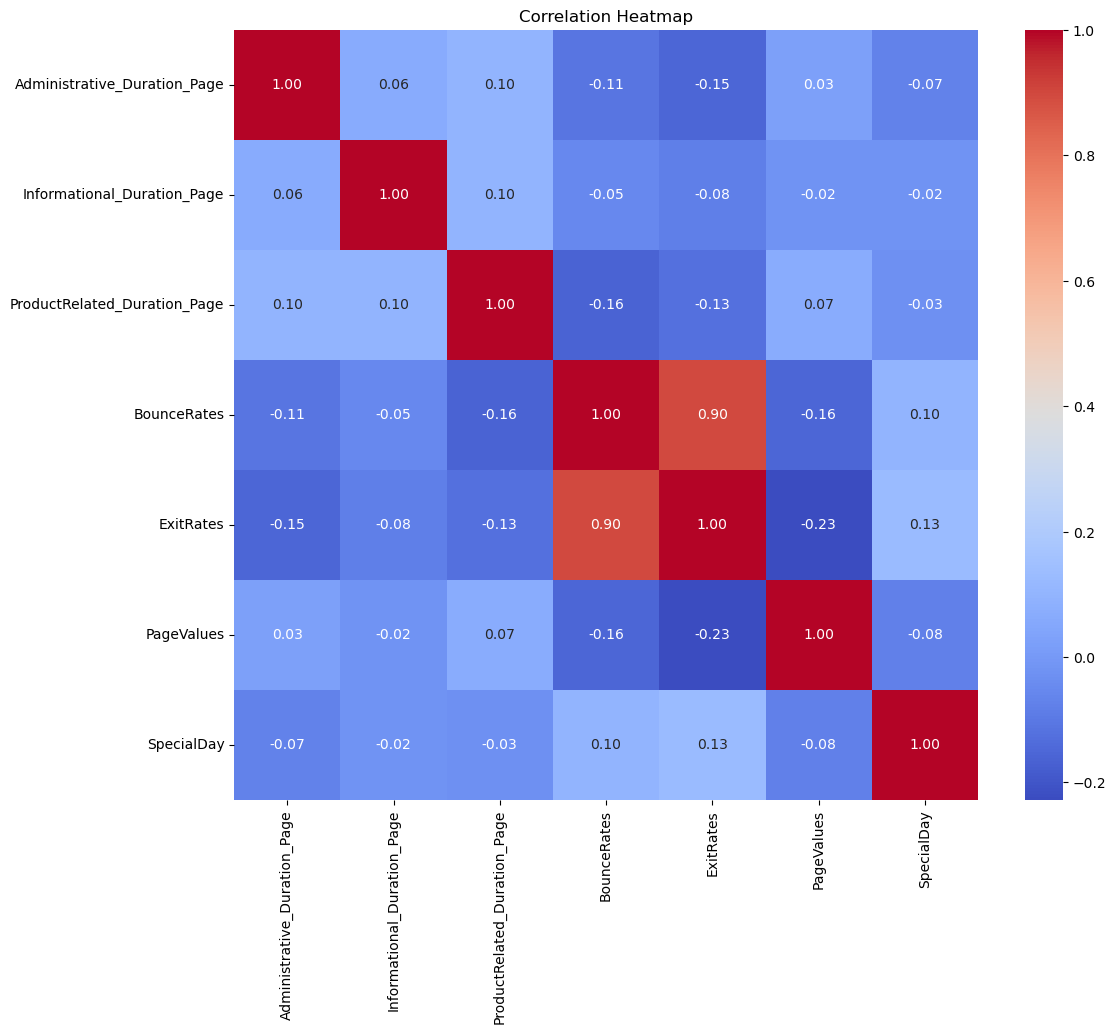

In [842]:
plt.figure(figsize=(12 , 10))
sns.heatmap(X_train_smote[numerical_columns].corr(), cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlation Heatmap')

In [844]:
X_train_smote.columns

Index(['Weekend_True', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Rest', 'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'Browser_2', 'Browser_3', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_13', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [845]:
categorical_columns=['Weekend_True', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Rest', 'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'Browser_2', 'Browser_3', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_13',]

In [846]:
def ChiSquareContingency(data, y_train):
    p_value = chi2_contingency(pd.crosstab(data, y_train))[1]
    print(f'p-value: {p_value}')
    if p_value > 0.05:
        print(f'Accept H0, feature {data.name} is independent with Revenue')
    else:
        print(f'Reject H0, feature {data.name} is dependent with Revenue')

# Assuming you are iterating over categorical columns
for column in categorical_columns:
    ChiSquareContingency(X_train_smote[column], y_train_smote)
    print('')

p-value: 0.0508422944096936
Accept H0, feature Weekend_True is independent with Revenue

p-value: 1.777132216226594e-07
Reject H0, feature Month_June is dependent with Revenue

p-value: 7.961422980876509e-11
Reject H0, feature Month_Mar is dependent with Revenue

p-value: 5.090618167448863e-20
Reject H0, feature Month_May is dependent with Revenue

p-value: 8.996637110317326e-43
Reject H0, feature Month_Nov is dependent with Revenue

p-value: 0.10814546522581941
Accept H0, feature Month_Rest is independent with Revenue

p-value: 0.006019822650304332
Reject H0, feature VisitorType_Other is dependent with Revenue

p-value: 0.0016388431663463868
Reject H0, feature VisitorType_Returning_Visitor is dependent with Revenue

p-value: 2.8283484085083395e-08
Reject H0, feature OperatingSystems_2 is dependent with Revenue

p-value: 1.2777045646412664e-21
Reject H0, feature OperatingSystems_3 is dependent with Revenue

p-value: 0.07149966228734056
Accept H0, feature OperatingSystems_4 is independe

<Axes: xlabel='Revenue', ylabel='SpecialDay'>

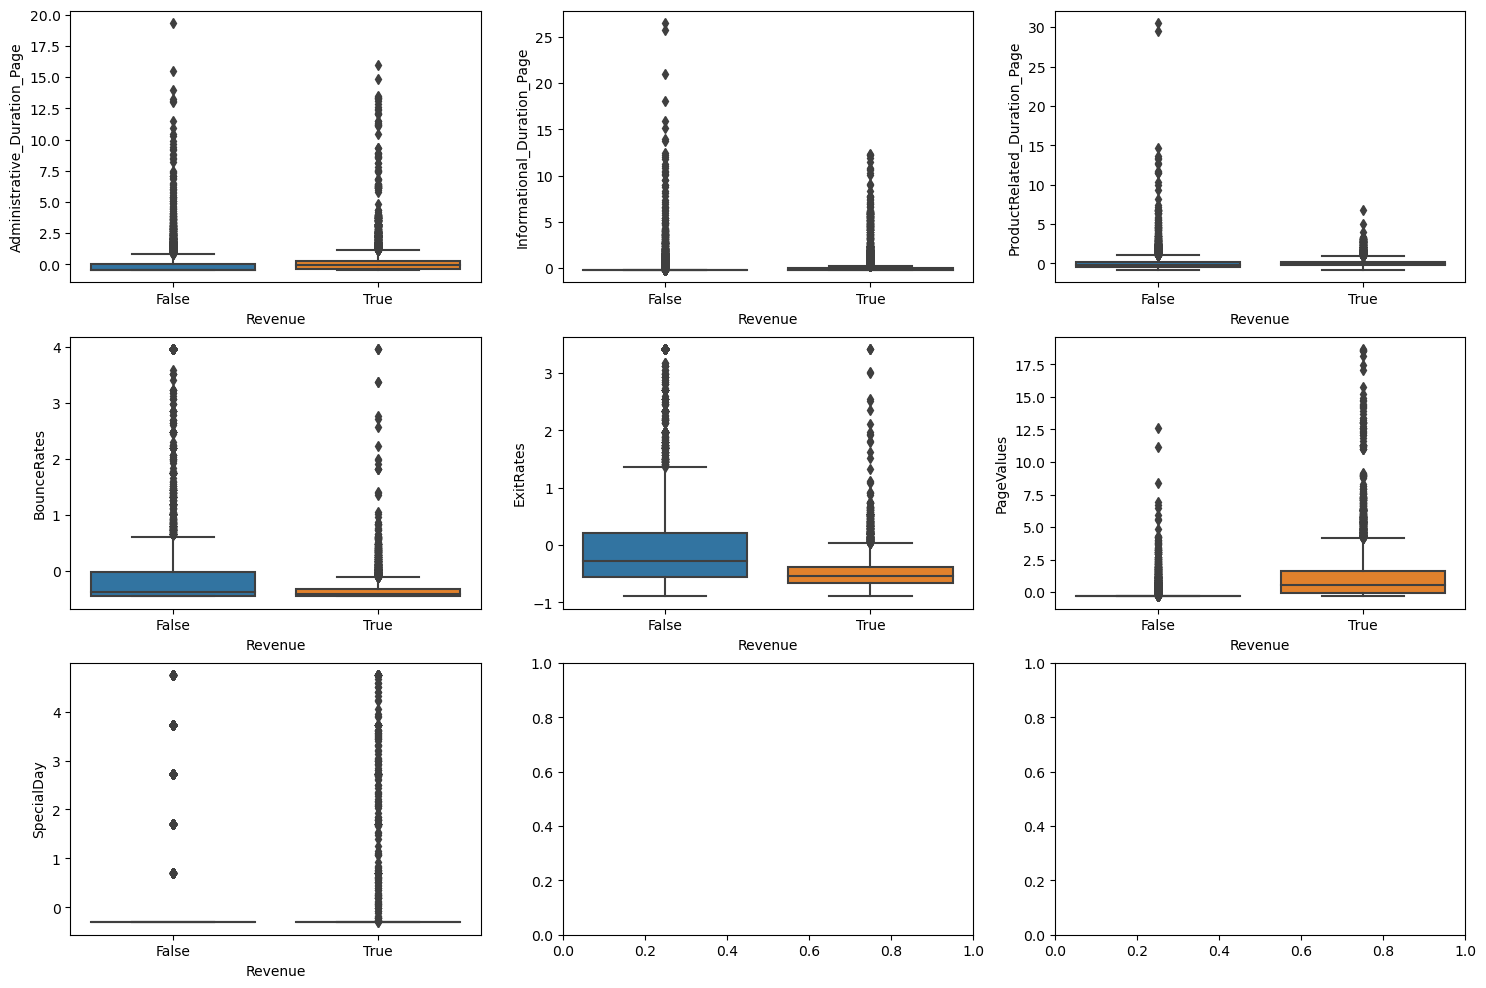

In [413]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


sns.boxplot(ax=axes[0, 0], x=y_train_smote, y=X_train_smote['Administrative_Duration_Page'])
sns.boxplot(ax=axes[0, 1], x=y_train_smote, y=X_train_smote['Informational_Duration_Page'])
sns.boxplot(ax=axes[0, 2], x=y_train_smote, y=X_train_smote['ProductRelated_Duration_Page'])
sns.boxplot(ax=axes[1, 0], x=y_train_smote, y=X_train_smote['BounceRates'])
sns.boxplot(ax=axes[1, 1], x=y_train_smote, y=X_train_smote['ExitRates'])
sns.boxplot(ax=axes[1, 2], x=y_train_smote, y=X_train_smote['PageValues'])
sns.boxplot(ax=axes[2, 0], x=y_train_smote, y=X_train_smote['SpecialDay'])



In [419]:
# fig, axes = plt.subplots(7, 7, figsize=(18, 12))

# # Flatten the axes array to easily iterate over subplots
# axes = axes.flatten()

# # Loop through each categorical column and create a countplot in each subplot
# for i, column in enumerate(catColsnew):
#     sns.countplot(x=X_train_smote[column], hue=y_train_smote, ax=axes[i])
#     axes[i].set_title(f'Countplot of {column} by Revenue')
#     axes[i].legend(title='Revenue')
    
    

# # Adjust layout to prevent overlap of subplots
# plt.tight_layout()
# plt.show()


# advanced analysis


## advanced analysis without smote

### Random forest 

In [1079]:
rfs = RandomForestClassifier()
rfs.fit(X_train, y_train)
eval_(rfs)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.90
Precision Score (Train set):1.00
Precision Score (Test set):0.72
Recall Score (Train set):0.82
Recall Score (Test set):0.56
F1 Score (Train set):0.90
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[7182    0]
 [1268 5914]]


In [1080]:
rfs_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
#                   'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10]} 

In [1081]:
rfs = RandomForestClassifier(random_state=42)
rfs_grid = GridSearchCV(rfs, param_grid = rfs_param_grid, cv = 3,scoring='roc_auc')

In [1082]:
score=rfs_grid.fit(X_train,y_train)

In [1083]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'n_estimators': 150}

In [1084]:
best_rfs_grid=score.best_estimator_

In [1085]:
eval_(best_rfs_grid)

Accuracy Score(Train set): 0.78
Accuracy Score(Test set): 0.90
Precision Score (Train set):0.96
Precision Score (Test set):0.74
Recall Score (Train set):0.58
Recall Score (Test set):0.54
F1 Score (Train set):0.72
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[7002  180]
 [3009 4173]]


In [1094]:
fpr9,tpr9,thresh=roc_curve(y_test,best_rfs_grid.predict(X_test))
auc9=auc(fpr9,tpr9)

## advanced analysis with smote

In [934]:
# y_train_smote.value_counts().plot(kind='bar')
# plt.show()

### Logistic Regression


In [935]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import shap

In [936]:
def eval_(model):
    y_pred=model.predict(X_test)
    y_pred_train=model.predict(X_train_smote)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train_smote)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [937]:
X_train.columns

Index(['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'Browser_2', 'Browser_3',
       'Region_2', 'Region_3', 'Region_4', 'Region_5', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_13',
       'BounceRates', 'ExitRates', 'PageValues',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page'],
      dtype='object')

In [938]:
X_test.columns

Index(['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'Browser_2', 'Browser_3',
       'Region_2', 'Region_3', 'Region_4', 'Region_5', 'TrafficType_2',
       'TrafficType_3', 'TrafficType_4', 'TrafficType_5', 'TrafficType_13',
       'BounceRates', 'ExitRates', 'PageValues',
       'Administrative_Duration_Page', 'Informational_Duration_Page',
       'ProductRelated_Duration_Page'],
      dtype='object')

In [939]:
logModel=LogisticRegression()
logModel.fit(X_train_smote,y_train_smote)

LogisticRegression()

In [940]:
eval_(logModel)

Accuracy Score(Train set): 0.82
Accuracy Score(Test set): 0.84
Precision Score (Train set):0.84
Precision Score (Test set):0.48
Recall Score (Train set):0.80
Recall Score (Test set):0.79
F1 Score (Train set):0.82
F1 Score (Test set):0.59
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6093 1089]
 [1443 5739]]


#### Logistic regression - hyperparameter tuning

In [942]:
logModel.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [943]:
param_grid={'solver':['sag','saga','newton-cholesky'],
         'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'C':np.linspace(0.001, 0.2, 20),
         'max_iter' : [100, 300,500, 1000]}

In [944]:
logModel1=LogisticRegression()

In [945]:
log_grid = GridSearchCV(logModel1, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

In [946]:
score=log_grid.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


In [947]:
score.best_params_

{'C': 0.16857894736842105, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [948]:
best_log_grid=score.best_estimator_

In [949]:
eval_(best_log_grid)

Accuracy Score(Train set): 0.82
Accuracy Score(Test set): 0.84
Precision Score (Train set):0.84
Precision Score (Test set):0.48
Recall Score (Train set):0.80
Recall Score (Test set):0.79
F1 Score (Train set):0.82
F1 Score (Test set):0.59
ROC AUC Score (Train-proba): 0.91
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6095 1087]
 [1447 5735]]


<Axes: ylabel='Feature'>

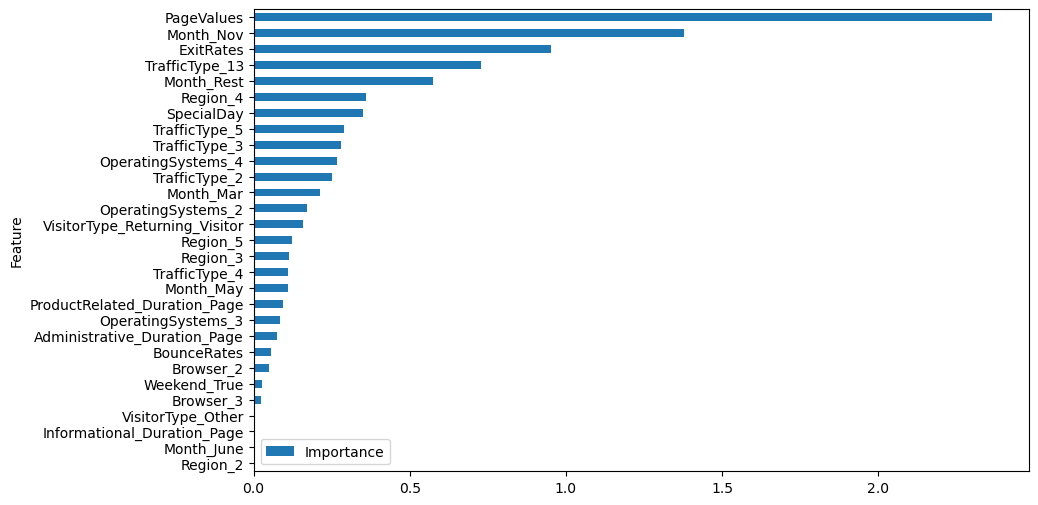

In [950]:
coefficients = best_log_grid.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train_smote.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

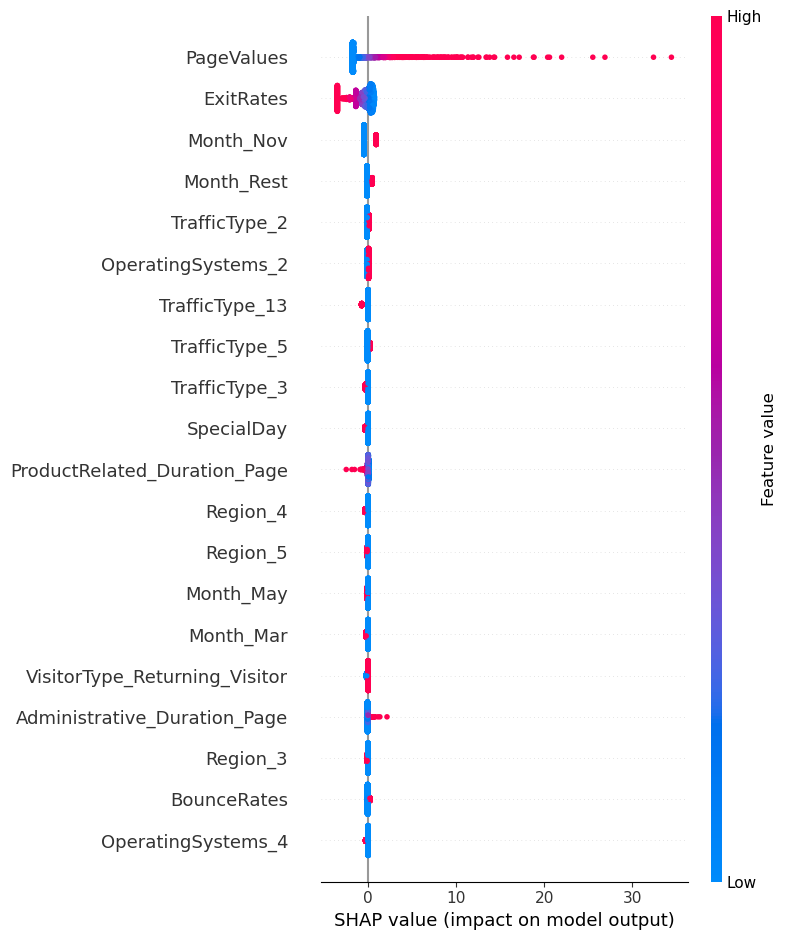

In [951]:
explainer = shap.LinearExplainer(best_log_grid, X_train_smote)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [1015]:
from sklearn.metrics import roc_curve,auc
fpr1,tpr1,thresh=roc_curve(y_test,best_log_grid.predict(X_test))
auc1=auc(fpr1,tpr1)


### KNN

In [956]:
from sklearn.neighbors import KNeighborsClassifier

In [957]:
knn = KNeighborsClassifier()
knn.fit(X_train_smote, y_train_smote)
eval_(knn)

Accuracy Score(Train set): 0.93
Accuracy Score(Test set): 0.78
Precision Score (Train set):0.87
Precision Score (Test set):0.38
Recall Score (Train set):1.00
Recall Score (Test set):0.68
F1 Score (Train set):0.93
F1 Score (Test set):0.48
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.81
Confusion Matrix:
  [[6157 1025]
 [  35 7147]]


In [958]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### KNN-hyperparameter tuning

In [959]:
param_grid={'n_neighbors': [5,10,50,100],
            'p' : [1,2],
            'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
           }

In [960]:
knn1=KNeighborsClassifier()

In [961]:
knn_grid = GridSearchCV(knn1, param_grid = param_grid, cv = 3,scoring='roc_auc')

In [962]:
score=knn_grid.fit(X_train_smote,y_train_smote)

In [963]:
score.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1}

In [964]:
best_knn_grid=score.best_estimator_

In [965]:
eval_(best_knn_grid)

Accuracy Score(Train set): 0.95
Accuracy Score(Test set): 0.82
Precision Score (Train set):0.91
Precision Score (Test set):0.43
Recall Score (Train set):0.99
Recall Score (Test set):0.58
F1 Score (Train set):0.95
F1 Score (Test set):0.50
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.79
Confusion Matrix:
  [[6475  707]
 [  45 7137]]


In [291]:
# f = lambda x: best_knn_grid.predict_proba(x)[:, 1]
# med = X_train_smote.median().values.reshape((1, X_train_smote.shape[1]))

# explainer = shap.Explainer(f, med)
# shap_values = explainer(X_test.iloc[0:1000, :])
# shap.plots.beeswarm(shap_values)

In [1014]:
fpr2,tpr2,thresh=roc_curve(y_test,best_knn_grid.predict(X_test))
auc2=auc(fpr2,tpr2)

### Random forest

In [966]:
from sklearn.ensemble import RandomForestClassifier

In [967]:
rf = RandomForestClassifier()
rf.fit(X_train_smote, y_train_smote)
eval_(rf)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.87
Precision Score (Train set):1.00
Precision Score (Test set):0.55
Recall Score (Train set):1.00
Recall Score (Test set):0.74
F1 Score (Train set):1.00
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


In [968]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Random Forest- Hyperparameter tuning

In [969]:
rf_param_grid = {'n_estimators': [50,100,150], 
                  'criterion': ['gini', 'entropy'],
                  'max_features': ['None','sqrt', 'log2'],
                  'max_depth' :[5,6,10],
#                   'min_samples_split': [2,10],
                  'min_samples_leaf' : [7,10] ,} 

In [970]:
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid = rf_param_grid, cv = 3,scoring='roc_auc')

In [971]:
score=rf_grid.fit(X_train_smote,y_train_smote)

In [972]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'n_estimators': 150}

In [973]:
best_rf_grid=score.best_estimator_

In [974]:
eval_(best_rf_grid)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.53
Recall Score (Train set):0.94
Recall Score (Test set):0.82
F1 Score (Train set):0.92
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6430  752]
 [ 454 6728]]


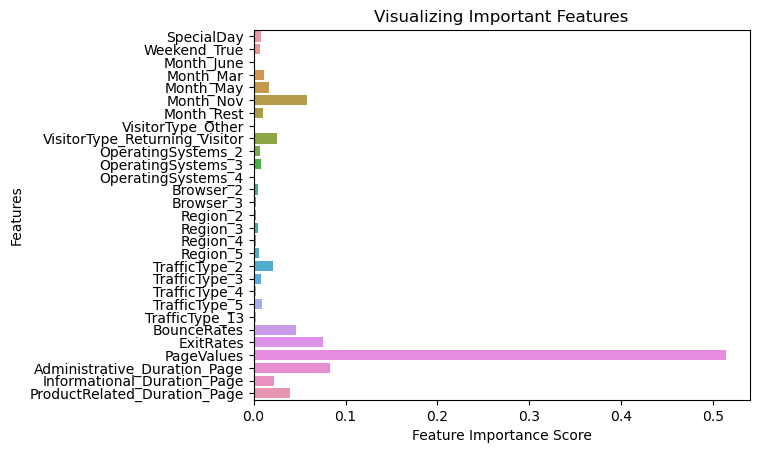

In [975]:
feature_imp1 = best_rf_grid.feature_importances_

sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [1013]:
fpr3,tpr3,thresh=roc_curve(y_test,best_rf_grid.predict(X_test))
auc3=auc(fpr3,tpr3)

### Decision tree

In [976]:
from sklearn.tree import DecisionTreeClassifier

In [977]:
dt = DecisionTreeClassifier()
dt.fit(X_train_smote, y_train_smote)
eval_(dt)

Accuracy Score(Train set): 1.00
Accuracy Score(Test set): 0.84
Precision Score (Train set):1.00
Precision Score (Test set):0.47
Recall Score (Train set):1.00
Recall Score (Test set):0.63
F1 Score (Train set):1.00
F1 Score (Test set):0.54
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.75
Confusion Matrix:
  [[7182    0]
 [   0 7182]]


#### Decision tree-Hyperparameter tuning

In [982]:
dt_param_grid={
    'max_depth' :[5,6,10],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [2, 7] ,
    'max_features' : ['auto', 'sqrt'],
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random']
}

In [983]:
dt = DecisionTreeClassifier(random_state = 42)
dt_grid = GridSearchCV(dt, param_grid = dt_param_grid, cv = 3,scoring='roc_auc')

In [984]:
score=dt_grid.fit(X_train_smote,y_train_smote)

In [985]:
score.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'splitter': 'best'}

In [986]:
best_dt_grid=score.best_estimator_

In [987]:
eval_(best_dt_grid)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.91
Precision Score (Test set):0.55
Recall Score (Train set):0.88
Recall Score (Test set):0.73
F1 Score (Train set):0.90
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.89
Confusion Matrix:
  [[6555  627]
 [ 842 6340]]


In [1012]:
fpr4,tpr4,thresh=roc_curve(y_test,best_dt_grid.predict(X_test))
auc4=auc(fpr4,tpr4)

### AdaBoost

In [989]:
from sklearn.ensemble import AdaBoostClassifier

In [990]:
ab = AdaBoostClassifier()
ab.fit(X_train_smote, y_train_smote)
eval_(ab)

Accuracy Score(Train set): 0.90
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.90
Precision Score (Test set):0.54
Recall Score (Train set):0.89
Recall Score (Test set):0.77
F1 Score (Train set):0.90
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.96
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[6464  718]
 [ 755 6427]]


In [991]:
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

#### AdaBoost - Hyperparameter Tuning -without base estimator

In [992]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200],   
}

In [993]:
ab = AdaBoostClassifier(random_state=42)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [994]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [995]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [996]:
best_ab_grid=score.best_estimator_

In [997]:
eval_(best_ab_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.91
Precision Score (Test set):0.56
Recall Score (Train set):0.91
Recall Score (Test set):0.74
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6554  628]
 [ 615 6567]]


#### AdaBoost - Hyperparameter Tuning -with base estimator

In [998]:
ab_param_grid={
    'algorithm': ['SAMME.R'],
    'learning_rate':[0.001,0.1,1],
    'n_estimators':[50,100,200]
}

In [999]:
dt_ada = DecisionTreeClassifier(random_state = 42,max_depth=6)
ab = AdaBoostClassifier(random_state=42,estimator=dt_ada)
ab_grid = GridSearchCV(ab, param_grid = ab_param_grid, cv = 3,scoring='roc_auc')

In [1000]:
score=ab_grid.fit(X_train_smote,y_train_smote)

In [1001]:
score.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}

In [744]:
best_ab_grid=score.best_estimator_

In [1002]:
eval_(best_ab_grid)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.91
Precision Score (Test set):0.56
Recall Score (Train set):0.91
Recall Score (Test set):0.74
F1 Score (Train set):0.91
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.90
Confusion Matrix:
  [[6554  628]
 [ 615 6567]]


In [1011]:
fpr5,tpr5,thresh=roc_curve(y_test,best_ab_grid.predict(X_test))
auc5=auc(fpr5,tpr5)

### Gradient Boosting


In [1003]:
from sklearn.ensemble import GradientBoostingClassifier

In [1004]:
gb = GradientBoostingClassifier()
gb.fit(X_train_smote, y_train_smote)
eval_(gb)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.91
Precision Score (Test set):0.56
Recall Score (Train set):0.94
Recall Score (Test set):0.79
F1 Score (Train set):0.93
F1 Score (Test set):0.65
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6550  632]
 [ 456 6726]]


#### Gradient Boosting - Hyperparameter Tuning

In [1005]:
gb_param_grid={
    'n_estimators':[50,100,150],
    'max_depth':[4,5,6],
    'max_features':['log2','sqrt',None],
    #'min_samples_leaf': [2],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}

In [1006]:
gb= GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grid = gb_param_grid, cv = 3,scoring='roc_auc')

In [1007]:
score=gb_grid.fit(X_train_smote,y_train_smote)

In [1008]:
score.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 150,
 'subsample': 0.6}

In [1009]:
best_gb_grid=score.best_estimator_

In [1010]:
eval_(best_gb_grid)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.95
Precision Score (Test set):0.56
Recall Score (Train set):0.97
Recall Score (Test set):0.74
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6853  329]
 [ 201 6981]]


In [1016]:
fpr6,tpr6,thresh=roc_curve(y_test,best_gb_grid.predict(X_test))
auc6=auc(fpr6,tpr6)

### XGBoost 

In [1017]:
from xgboost import XGBClassifier

In [1018]:
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)
eval_(xgb)

Accuracy Score(Train set): 0.99
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.99
Precision Score (Test set):0.54
Recall Score (Train set):0.99
Recall Score (Test set):0.70
F1 Score (Train set):0.99
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 1.00
ROC AUC Score (Test-proba): 0.91
Confusion Matrix:
  [[7090   92]
 [  99 7083]]


#### XGBoost - Hyperparameter Tuning

In [1019]:
xgb_param_grid={
    'max_depth':[4,5,6],
    'n_estimators':[100,200,300],
    'colsample_bytree':[0.1,0.5,1],
    'learning_rate':[0.001,0.1,1],
    'subsample':[0.5,0.6]
    
}

In [1020]:
xgb= XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb, param_grid = xgb_param_grid, cv = 3,scoring='roc_auc')

In [1021]:
score=xgb_grid.fit(X_train_smote,y_train_smote)

In [1022]:
score.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 300,
 'subsample': 0.6}

In [1023]:
best_xgb_grid=score.best_estimator_

In [1024]:
eval_(best_gb_grid)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.87
Precision Score (Train set):0.95
Precision Score (Test set):0.56
Recall Score (Train set):0.97
Recall Score (Test set):0.74
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6853  329]
 [ 201 6981]]


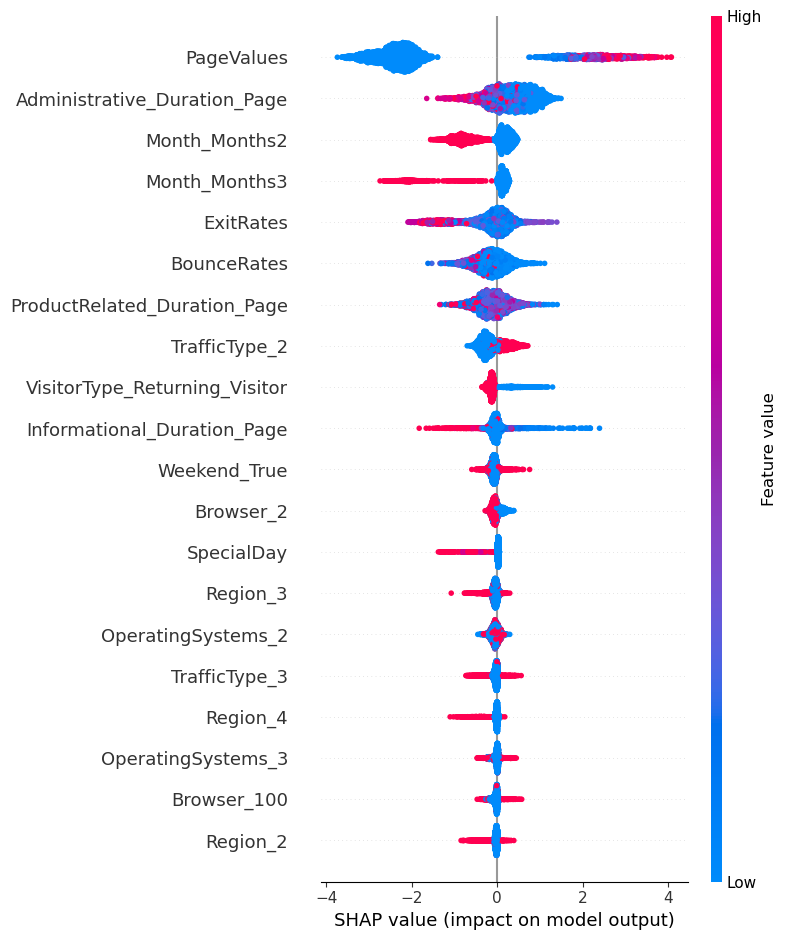

In [762]:
explainer = shap.TreeExplainer(best_xgb_grid)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [1091]:
fpr7,tpr7,thresh=roc_curve(y_test,best_xgb_grid.predict(X_test))
auc7=auc(fpr7,tpr7)

### SVM

In [1027]:
from sklearn.svm import SVC

In [1028]:
svc = SVC(probability=True)
svc.fit(X_train_smote, y_train_smote)
eval_(svc)

Accuracy Score(Train set): 0.89
Accuracy Score(Test set): 0.85
Precision Score (Train set):0.88
Precision Score (Test set):0.50
Recall Score (Train set):0.90
Recall Score (Test set):0.77
F1 Score (Train set):0.89
F1 Score (Test set):0.61
ROC AUC Score (Train-proba): 0.95
ROC AUC Score (Test-proba): 0.88
Confusion Matrix:
  [[6311  871]
 [ 694 6488]]


In [1029]:
svc_param_grid = {'C': [0.1, 1,10,100], 
              'gamma': [0.1,0.01,0.001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

In [1195]:
svc= SVC(probability=True)
svc_grid = GridSearchCV(svc, param_grid = svc_param_grid, cv = 3,scoring='roc_auc')

In [1197]:
score=svc_grid.fit(X_train_smote,y_train_smote)

KeyboardInterrupt: 

In [1032]:
score.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [1033]:
best_svc_grid=score.best_estimator_

In [1034]:
eval_(best_svc_grid)

Accuracy Score(Train set): 0.97
Accuracy Score(Test set): 0.85
Precision Score (Train set):0.96
Precision Score (Test set):0.50
Recall Score (Train set):0.98
Recall Score (Test set):0.58
F1 Score (Train set):0.97
F1 Score (Test set):0.54


AttributeError: predict_proba is not available when  probability=False

In [1036]:
fpr8,tpr8,thresh=roc_curve(y_test,best_svc_grid.predict(X_test))
auc8=auc(fpr8,tpr8)

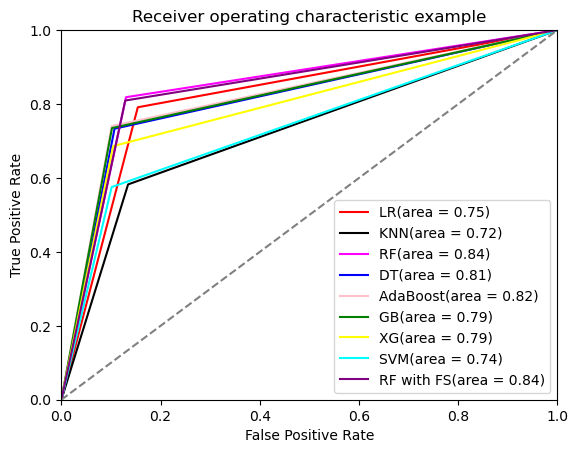

In [1174]:
plt.plot(fpr1,tpr1, label='LR(area = %0.2f)' % auc1,color='red')
plt.plot(fpr2, tpr2, label='KNN(area = %0.2f)' % auc2,color='black')
plt.plot(fpr3, tpr3, label='RF(area = %0.2f)' % auc3,color='magenta')
plt.plot(fpr4, tpr4, label='DT(area = %0.2f)' % auc4,color='blue')
plt.plot(fpr5, tpr5, label='AdaBoost(area = %0.2f)' % auc5,color='pink')
plt.plot(fpr6, tpr6, label='GB(area = %0.2f)' % auc6,color='green')
plt.plot(fpr7, tpr7, label='XG(area = %0.2f)' % auc7,color='yellow')
plt.plot(fpr8, tpr8, label='SVM(area = %0.2f)' % auc8,color='cyan')
#plt.plot(fpr9, tpr9, label='RF without smote(area = %0.2f)' % auc9,color='purple')
plt.plot(fpr10, tpr10, label='RF with FS(area = %0.2f)' % auc10,color='purple')


plt.plot([0, 1], [0, 1], 'k--',color='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Feature selection

In [1159]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesClassifier

In [1160]:
rfe=RFECV(estimator=ExtraTreesClassifier(),step=1,cv=3)

In [1161]:
model=rfe.fit(X_train_smote,y_train_smote)

In [1162]:
X_train_smote.columns[(model.get_support())]

Index(['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Returning_Visitor',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'Browser_2', 'Browser_3', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_13', 'BounceRates', 'ExitRates',
       'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [1163]:
selCols=['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Returning_Visitor',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'Browser_2', 'Browser_3', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_13', 'BounceRates', 'ExitRates',
       'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page']

In [1164]:
X_train_smote_new=X_train_smote[selCols].copy()

In [1165]:
y_train_smote.shape

(14364,)

In [1166]:
X_test_new=X_test[selCols].copy()

In [1167]:
X_test_new.columns

Index(['SpecialDay', 'Weekend_True', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Rest', 'VisitorType_Returning_Visitor',
       'OperatingSystems_2', 'OperatingSystems_3', 'OperatingSystems_4',
       'Browser_2', 'Browser_3', 'Region_2', 'Region_3', 'Region_4',
       'Region_5', 'TrafficType_2', 'TrafficType_3', 'TrafficType_4',
       'TrafficType_5', 'TrafficType_13', 'BounceRates', 'ExitRates',
       'PageValues', 'Administrative_Duration_Page',
       'Informational_Duration_Page', 'ProductRelated_Duration_Page'],
      dtype='object')

In [1168]:
X_test_new.shape

(3660, 28)

### Gradient Boosting with features selected

In [1176]:
gbm= GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth= 6,max_features='log2',n_estimators=150,
subsample=0.6)

In [1177]:
gbm.fit(X_train_smote_new,y_train_smote)


GradientBoostingClassifier(max_depth=6, max_features='log2', n_estimators=150,
                           random_state=42, subsample=0.6)

In [1067]:
def evalNew(model):
    y_pred=model.predict(X_test_new)
    y_pred_train=model.predict(X_train_smote_new)
    
    print("Accuracy Score(Train set): %.2f" % accuracy_score(y_train_smote, y_pred_train))
    print("Accuracy Score(Test set): %.2f" % accuracy_score(y_test, y_pred))
    
    print("Precision Score (Train set):%.2f" % precision_score(y_train_smote, y_pred_train))
    print("Precision Score (Test set):%.2f" % precision_score(y_test, y_pred))

    print("Recall Score (Train set):%.2f" % recall_score(y_train_smote, y_pred_train))
    print("Recall Score (Test set):%.2f" % recall_score(y_test, y_pred))

    print("F1 Score (Train set):%.2f" % f1_score(y_train_smote, y_pred_train))
    print("F1 Score (Test set):%.2f" % f1_score(y_test, y_pred))
    
    y_pred_proba = model.predict_proba(X_test_new)
    y_pred_proba_train = model.predict_proba(X_train_smote_new)
    
    print("ROC AUC Score (Train-proba): %.2f" % roc_auc_score (y_train_smote, y_pred_proba_train[:,1]))
    print("ROC AUC Score (Test-proba): %.2f" % roc_auc_score (y_test, y_pred_proba[:,1]))
    
    print('Confusion Matrix:\n ', confusion_matrix(y_train_smote, y_pred_train))

In [1178]:
evalNew(gbm)

Accuracy Score(Train set): 0.96
Accuracy Score(Test set): 0.88
Precision Score (Train set):0.95
Precision Score (Test set):0.57
Recall Score (Train set):0.97
Recall Score (Test set):0.73
F1 Score (Train set):0.96
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.99
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6835  347]
 [ 222 6960]]


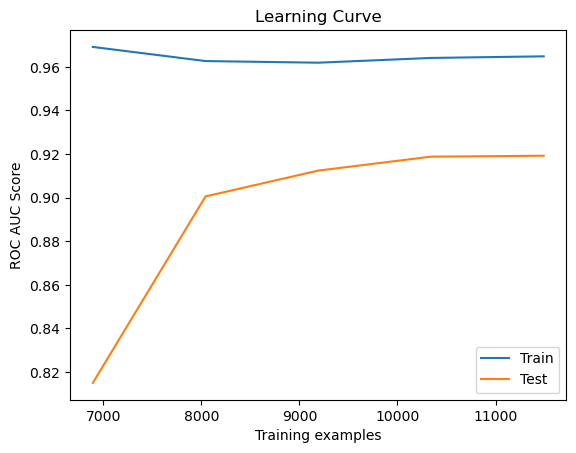

In [1179]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

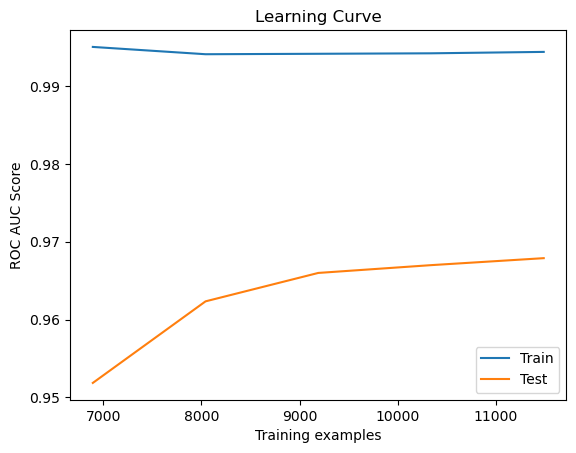

In [319]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [1191]:
fpr11,tpr11,thresh=roc_curve(y_test,gbm.predict(X_test_new))
auc11=auc(fpr11,tpr11)

### XGBoosting with feature selected

In [1181]:
xgm= XGBClassifier(random_state=42,learning_rate=0.1,max_depth= 6,subsample=0.7,min_child_weight=50)

In [1182]:
xgm.fit(X_train_smote_new,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [1183]:
evalNew(xgm)

Accuracy Score(Train set): 0.92
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.52
Recall Score (Train set):0.94
Recall Score (Test set):0.81
F1 Score (Train set):0.92
F1 Score (Test set):0.63
ROC AUC Score (Train-proba): 0.97
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6471  711]
 [ 441 6741]]


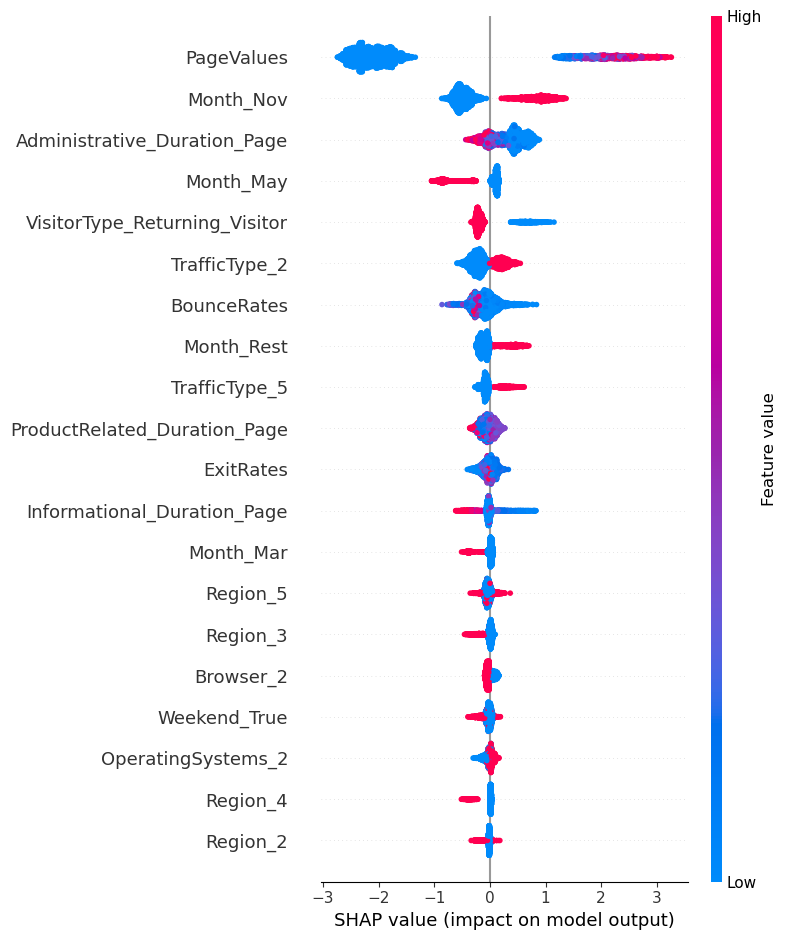

In [1184]:
explainer = shap.TreeExplainer(xgm)
shap_values = explainer.shap_values(X_test_new)
shap.summary_plot(shap_values, X_test_new)

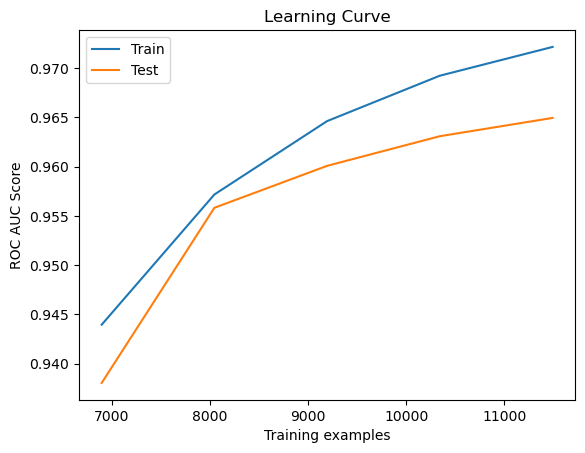

In [1187]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

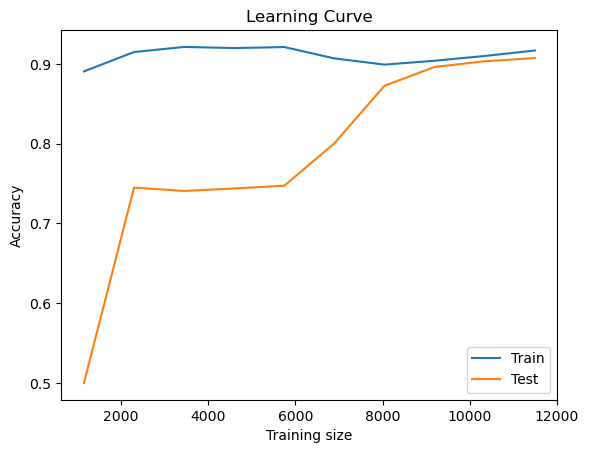

In [1188]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [1190]:
# from sklearn.inspection import PartialDependenceDisplay
# fig, ax = plt.subplots(figsize=(20,20 ))
# ax.set_title("Partial Dependence Plots")
# PartialDependenceDisplay.from_estimator(
#     estimator=xgm,
#     X=X_test_new,
#     features=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12),
#     random_state=5,
#     ax=ax,
# )
# plt.show()

In [1192]:
fpr12,tpr12,thresh=roc_curve(y_test,xgm.predict(X_test_new))
auc12=auc(fpr12,tpr12)

### Random Forest with features selected

In [1169]:
rfm= RandomForestClassifier(random_state=42,criterion='entropy',max_depth= 10,max_features='sqrt',min_samples_leaf=7,n_estimators=150)

In [1170]:
rfm.fit(X_train_smote_new,y_train_smote)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=7,
                       n_estimators=150, random_state=42)

In [1171]:
evalNew(rfm)

Accuracy Score(Train set): 0.91
Accuracy Score(Test set): 0.86
Precision Score (Train set):0.90
Precision Score (Test set):0.53
Recall Score (Train set):0.93
Recall Score (Test set):0.81
F1 Score (Train set):0.92
F1 Score (Test set):0.64
ROC AUC Score (Train-proba): 0.98
ROC AUC Score (Test-proba): 0.92
Confusion Matrix:
  [[6436  746]
 [ 490 6692]]


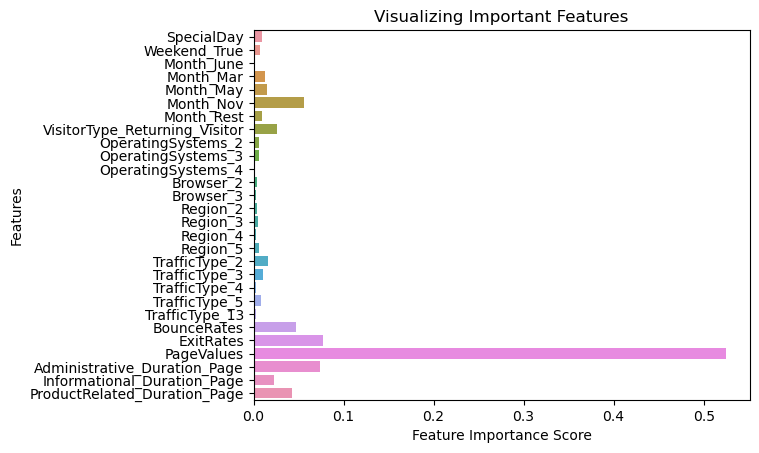

In [1172]:
feature_imp1 = rfm.feature_importances_

sns.barplot(x=feature_imp1, y=X_test_new.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

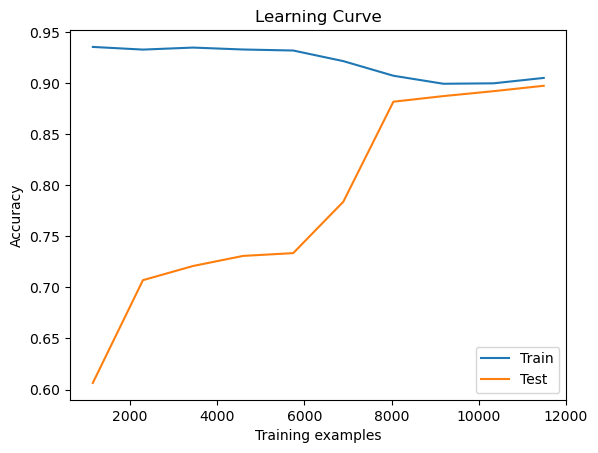

In [787]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

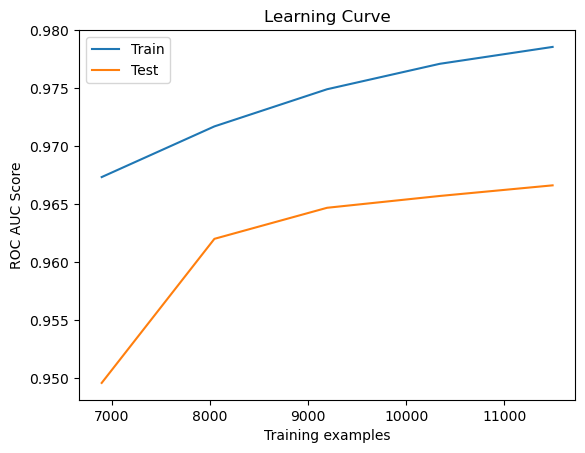

In [1175]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfm,
    X=X_train_smote_new,
    y=y_train_smote,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='roc_auc')

# Calculate mean train and test scores across CV folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Train')
plt.plot(train_sizes, test_scores_mean, label='Test')
plt.xlabel('Training examples')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [793]:
X_train_smote_new.shape

(14364, 32)

In [1104]:
# from sklearn.inspection import PartialDependenceDisplay
# fig, ax = plt.subplots(figsize=(20,20 ))
# ax.set_title("Partial Dependence Plots")
# PartialDependenceDisplay.from_estimator(
#     estimator=rfm,
#     X=X_test_new,
#     features=(0, 1, 2, 3,4,5,6,7,8,9,10,11,12),
#     random_state=5,
#     ax=ax,
# )
# plt.show()

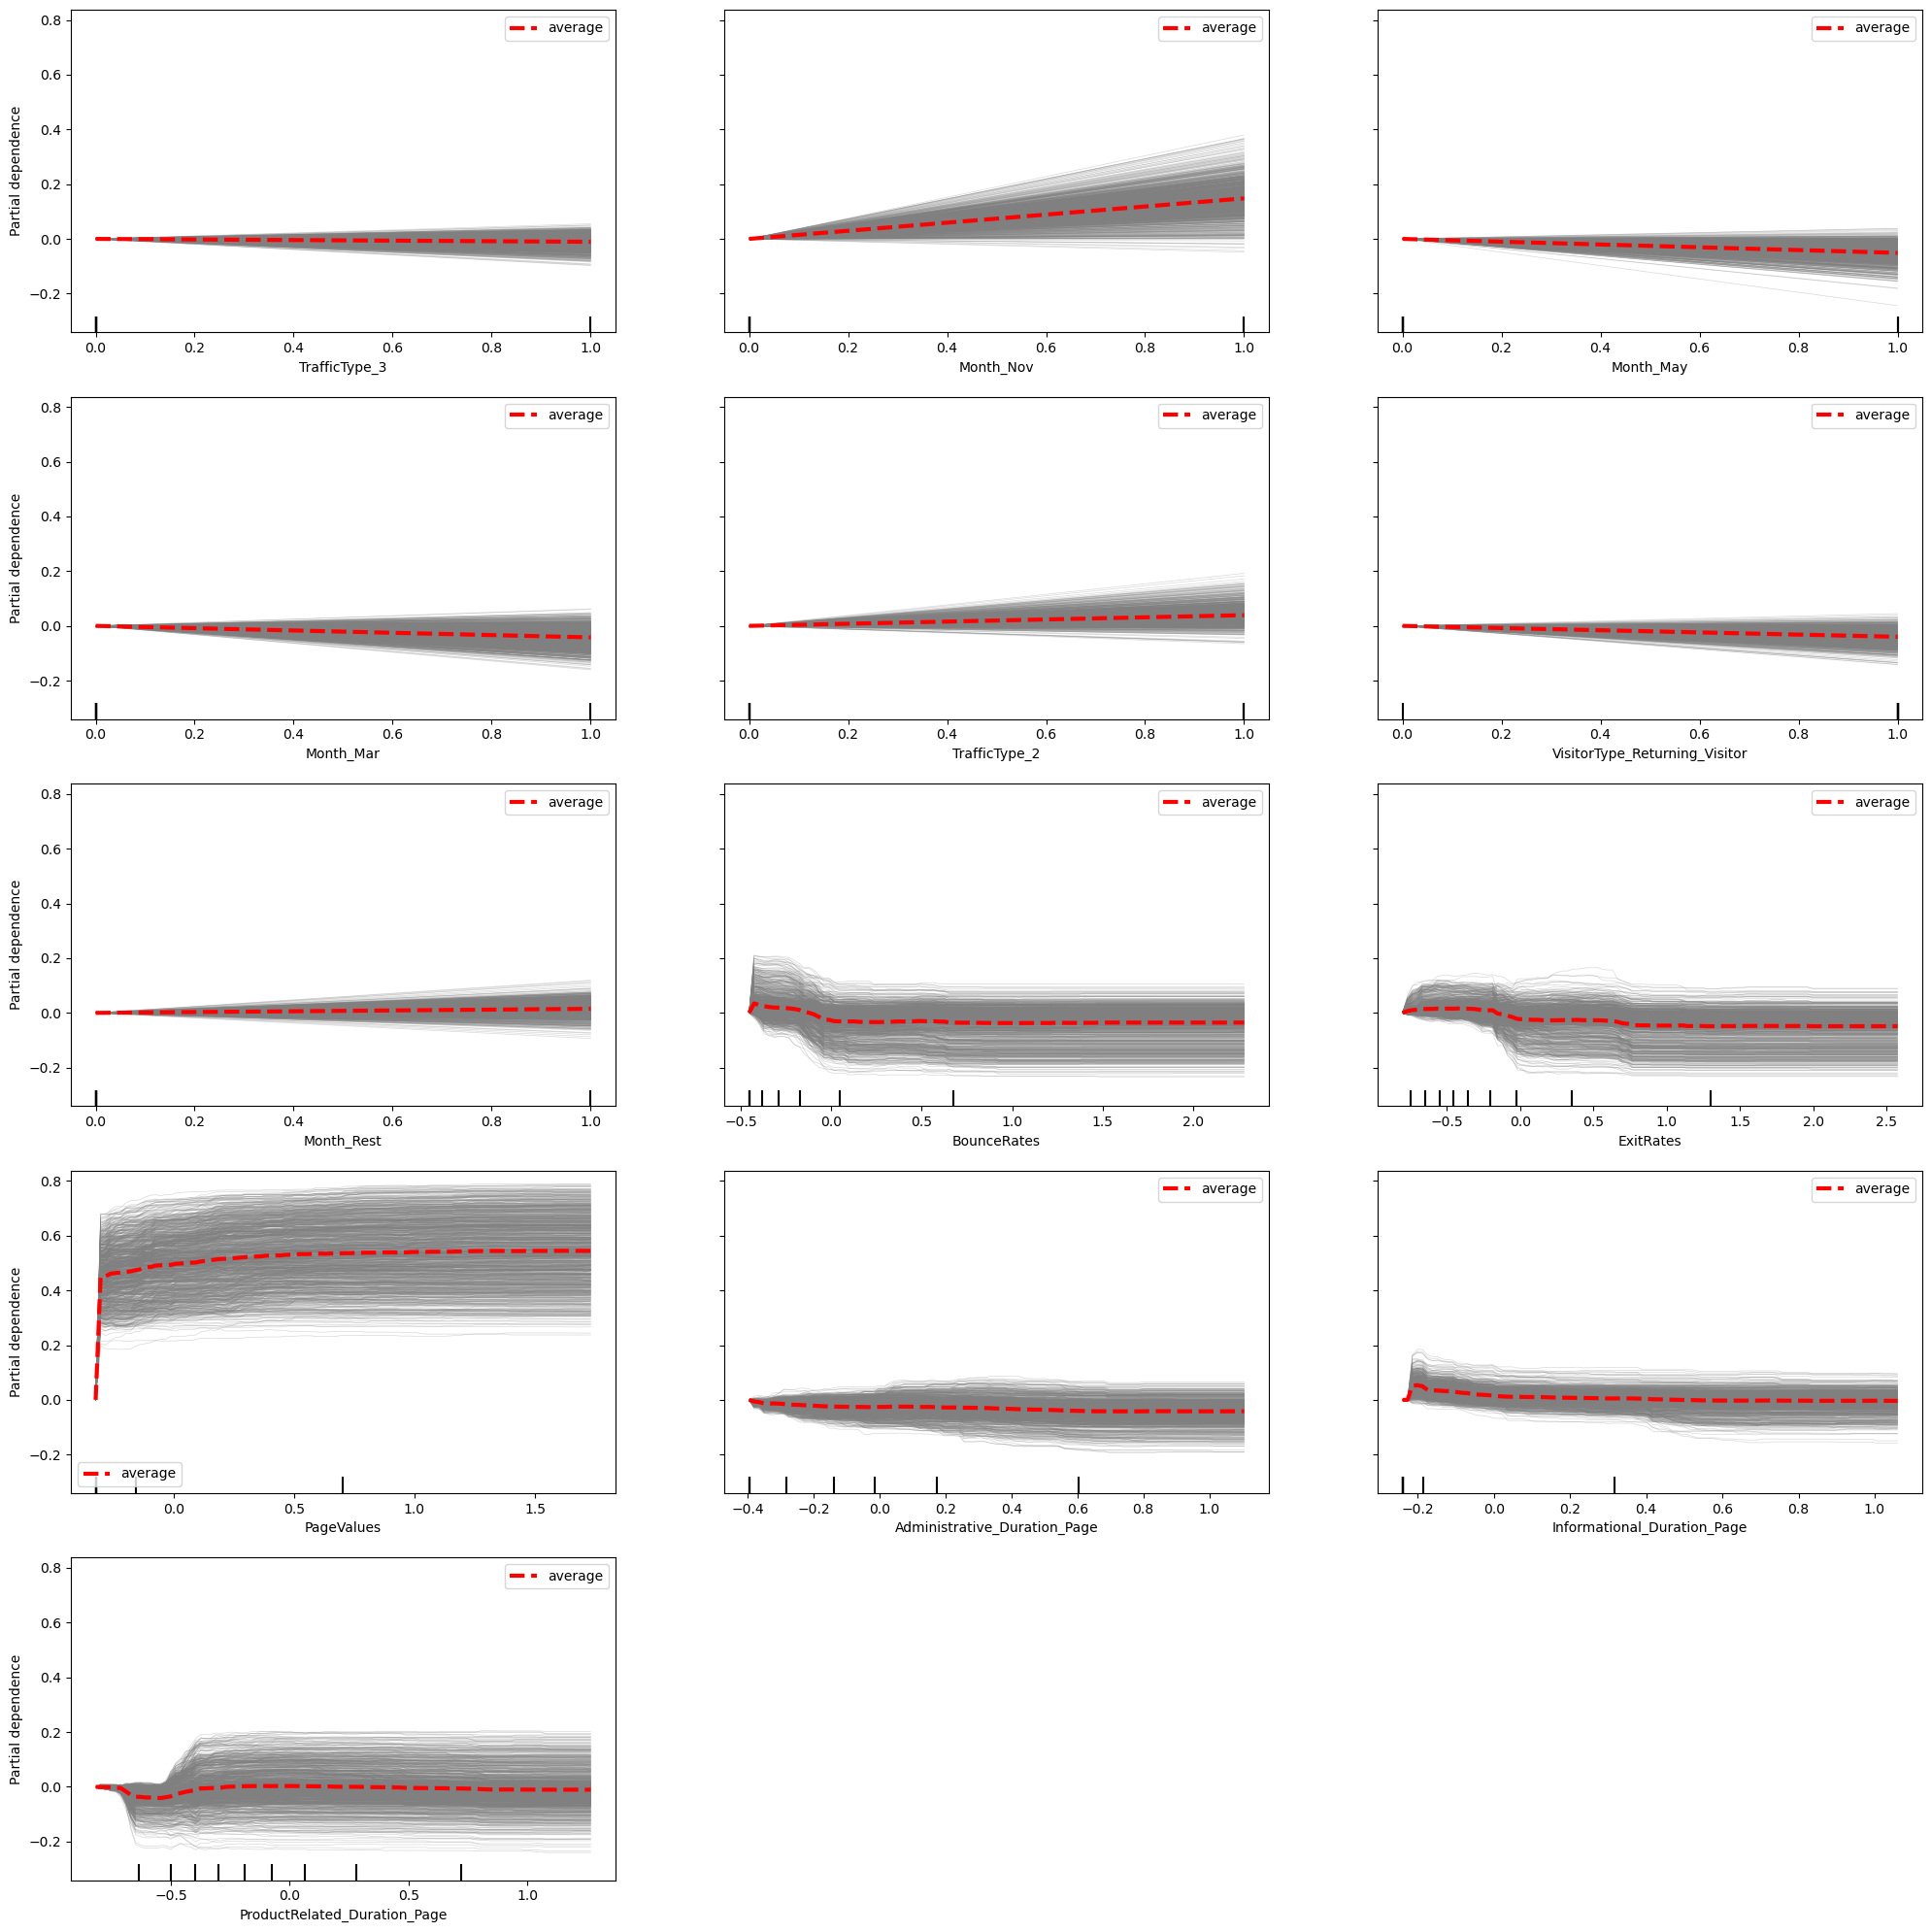

In [1103]:
from sklearn.inspection import PartialDependenceDisplay
cols = X_test_new.columns
included_features_indices = np.argpartition(rfm.feature_importances_, -13)[-13:]

fig, ax = plt.subplots(figsize=(20, 20))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=rfm,
                                            ax=ax,
                                            X=X_test_new,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

In [1193]:
fpr10,tpr10,thresh=roc_curve(y_test,rfm.predict(X_test_new))
auc10=auc(fpr10,tpr10)

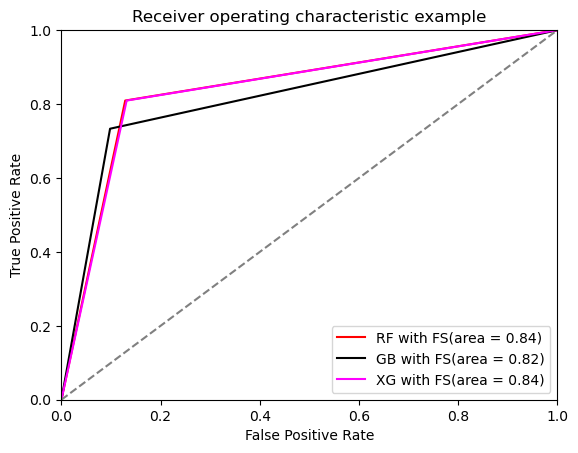

In [1194]:
plt.plot(fpr10,tpr10, label='RF with FS(area = %0.2f)' % auc10,color='red')
plt.plot(fpr11, tpr11, label='GB with FS(area = %0.2f)' % auc11,color='black')
plt.plot(fpr12, tpr12, label='XG with FS(area = %0.2f)' % auc12,color='magenta')



plt.plot([0, 1], [0, 1], 'k--',color='grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()